In [1]:
import pandas as pd
from tech_core.feature_pipeline import FeaturesPipeline
from tech_core.losses import StreamingSharpeLoss
from tech_core.nn_builder import SimplePortfolioAllocator, DeepPortfolioAllocator_1
import torch
from tqdm import tqdm

In [2]:
path_to_data = '../data/'

split_dates = [
    pd.Timestamp("2025-01-01")
]
split_names = ['train', 'test']

fee = 1.53e-4
padding = 35
batch_size_config = {
    0: 1000,
    # 40: 4000,
    # 80: 10000
}
num_epochs = 1000
adam_lr = 1e-1
log_freq = 5

In [3]:
prev_models = []

batch_size = batch_size_config[0]
pipeline = FeaturesPipeline(
    path_to_data,
    padding=padding,
    batch_size=batch_size,
    split_dates=split_dates,
    split_names=split_names
)

cmf_dim = asset_dim = num_assets = None
for common_feats, asset_feats, fut_ret, _, _ in tqdm(pipeline.iterate('train'), desc="Loading features"):
    cmf_dim = common_feats.shape[1]
    asset_dim = asset_feats.shape[2]
    num_assets = asset_feats.shape[1]
    break

print(f"cmf_dim: {cmf_dim}, asset_dim: {asset_dim}, num_assets: {num_assets}")

# model = DeepPortfolioAllocator_1(
#     cmf_dim=cmf_dim,
#     asset_dim=asset_dim,
#     num_assets=num_assets,
# )

model = SimplePortfolioAllocator(
    cmf_dim=cmf_dim,
    #asset_dim=asset_dim,
    num_assets=num_assets,
)

optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Loading features: 0it [00:00, ?it/s]


cmf_dim: 126, asset_dim: 5, num_assets: 488


SimplePortfolioAllocator(
  (tmp_simple_linear): Linear(in_features=126, out_features=489, bias=True)
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Changing batch size to 1000 at epoch 0


  0%|          | 4/1000 [03:50<15:44:05, 56.87s/it]

Sharpe Ratio for the epoch: 3.4843
Average Weights:



,Weight
Cash,0.410024
IRM,0.067845
GRMN,0.065528
IP,0.058028
BKNG,0.048825
...,...
DOW,0.000006
BBY,0.000005
AAL,0.000005
ALB,0.000005


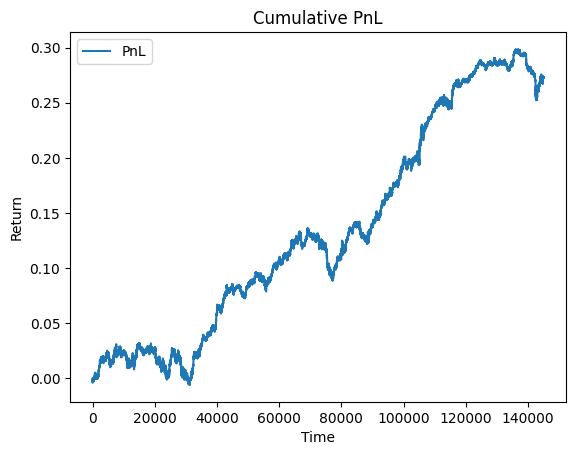

Epoch 5: Loss = -0.6533851027488708
Sharpe Ratio for the epoch: 4.5502
Average Weights:



,Weight
Cash,0.415353
IP,0.093554
BKNG,0.056044
IRM,0.052694
GRMN,0.043152
...,...
DOW,0.000005
BBY,0.000004
AAL,0.000004
ALB,0.000004


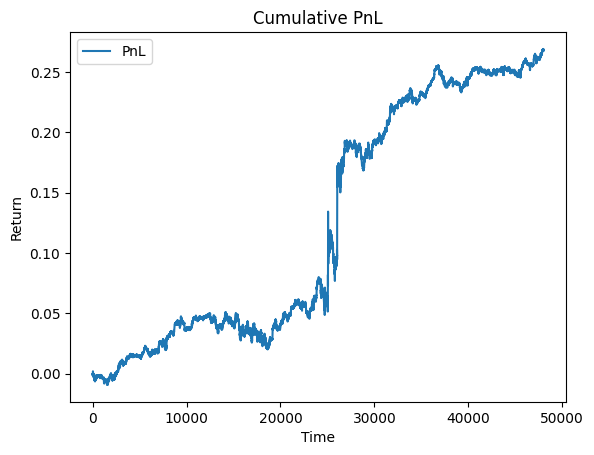

  1%|          | 9/1000 [08:15<14:42:30, 53.43s/it]

Sharpe Ratio for the epoch: 5.7109
Average Weights:



,Weight
Cash,8.696390e-01
FICO,1.637755e-02
MPWR,1.637092e-02
BKNG,1.390616e-02
GRMN,1.341142e-02
...,...
DOW,4.290137e-07
BBY,3.930606e-07
AAL,3.603663e-07
ALB,3.453312e-07


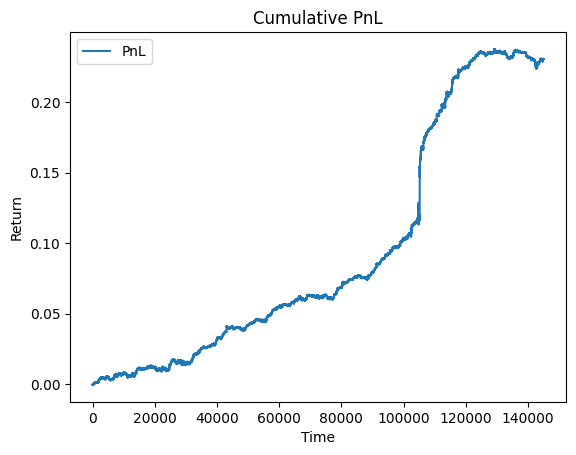

Epoch 10: Loss = -0.9859228134155273
Sharpe Ratio for the epoch: 4.3746
Average Weights:



,Weight
Cash,8.400437e-01
BKNG,2.167609e-02
GRMN,1.736088e-02
FICO,1.677582e-02
IRM,1.572916e-02
...,...
DOW,4.499485e-07
BBY,4.137836e-07
AAL,3.786869e-07
ALB,3.629637e-07


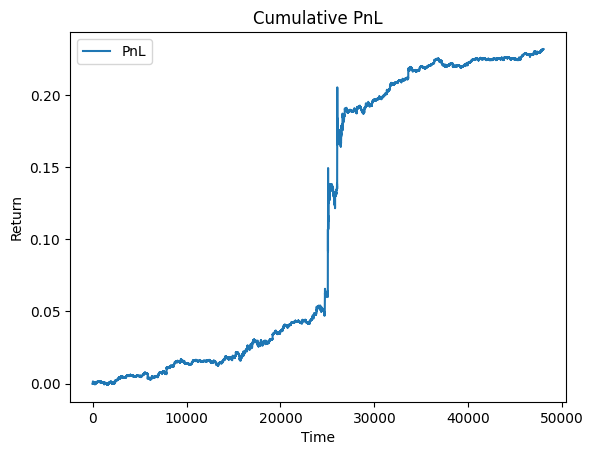

  1%|▏         | 14/1000 [12:41<14:35:53, 53.30s/it]

Sharpe Ratio for the epoch: 6.3556
Average Weights:



,Weight
Cash,8.796901e-01
MPWR,1.784208e-02
FICO,1.762786e-02
BKNG,1.335729e-02
GRMN,1.161949e-02
...,...
DOW,1.888320e-07
BBY,1.790312e-07
AAL,1.619725e-07
ALB,1.588967e-07


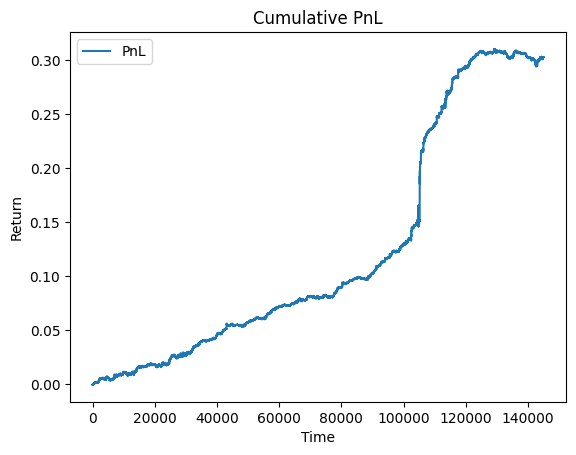

Epoch 15: Loss = -1.1388747692108154
Sharpe Ratio for the epoch: 6.2975
Average Weights:



,Weight
Cash,8.315936e-01
FICO,2.677201e-02
BKNG,2.253232e-02
GRMN,1.897568e-02
MPWR,1.718186e-02
...,...
DOW,2.267287e-07
BBY,2.148221e-07
AAL,1.943021e-07
ALB,1.906215e-07


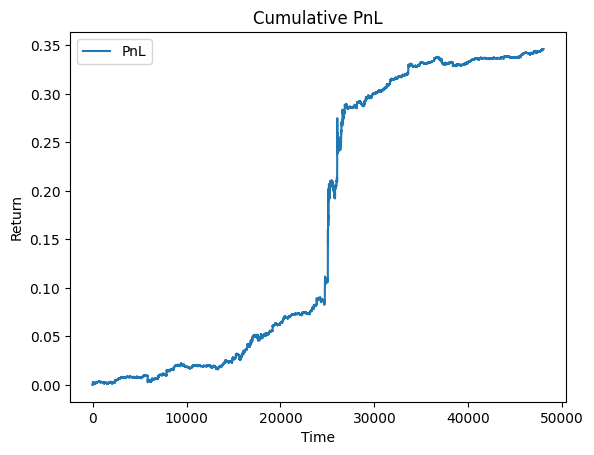

  2%|▏         | 19/1000 [17:11<14:41:50, 53.94s/it]

Sharpe Ratio for the epoch: 6.9449
Average Weights:



,Weight
Cash,8.847672e-01
MPWR,1.924521e-02
FICO,1.767226e-02
BKNG,1.191458e-02
GRMN,1.003881e-02
...,...
DOW,1.025932e-07
BBY,9.883414e-08
ALB,8.925019e-08
AAL,8.880819e-08


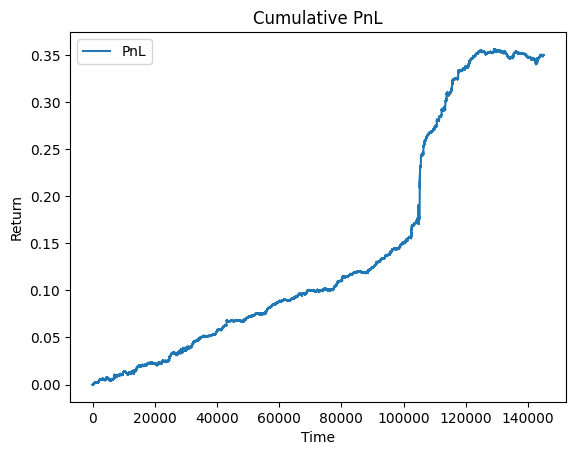

Epoch 20: Loss = -1.8389216661453247
Sharpe Ratio for the epoch: 7.5670
Average Weights:



,Weight
Cash,8.409601e-01
FICO,3.143269e-02
MPWR,2.022574e-02
BKNG,1.790316e-02
GRMN,1.672284e-02
...,...
DOW,1.208204e-07
BBY,1.160837e-07
ALB,1.048626e-07
AAL,1.043429e-07


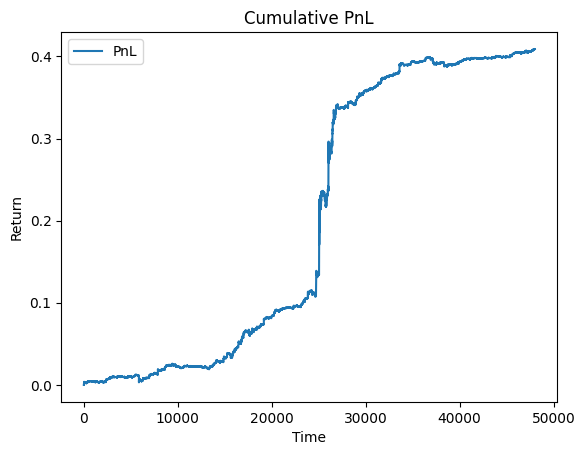

  2%|▏         | 24/1000 [21:47<14:51:50, 54.83s/it]

Sharpe Ratio for the epoch: 7.4209
Average Weights:



,Weight
Cash,8.876506e-01
MPWR,2.024605e-02
FICO,1.750268e-02
BKNG,1.133560e-02
MTD,9.769906e-03
...,...
TEL,6.024356e-08
BBY,5.997665e-08
ALB,5.509090e-08
AAL,5.355941e-08


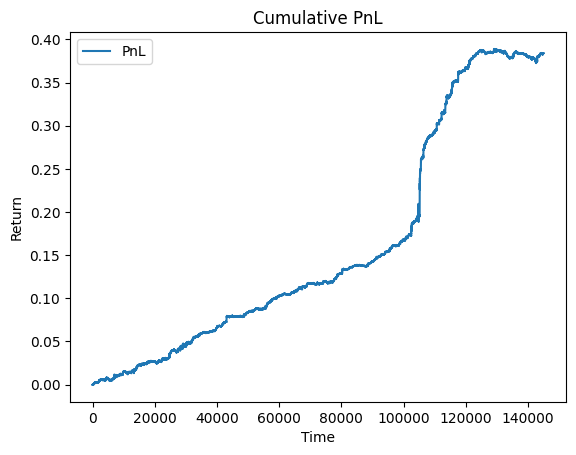

Epoch 25: Loss = -3.102426528930664
Sharpe Ratio for the epoch: 8.7458
Average Weights:



,Weight
Cash,8.500161e-01
FICO,3.243049e-02
MPWR,2.082807e-02
BKNG,1.535900e-02
GRMN,1.341354e-02
...,...
TEL,6.654550e-08
BBY,6.612934e-08
ALB,6.077362e-08
AAL,5.907832e-08


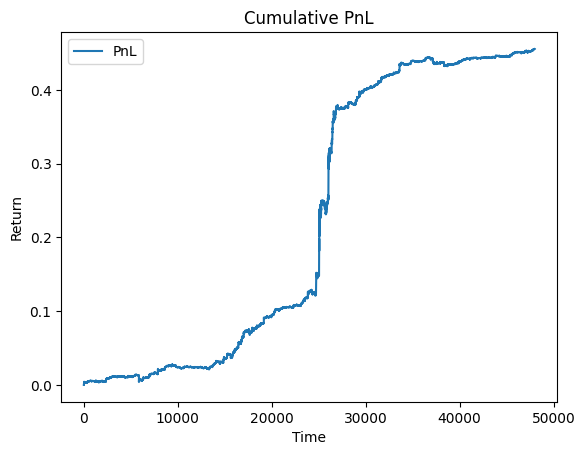

  3%|▎         | 29/1000 [26:02<13:45:23, 51.00s/it]

Sharpe Ratio for the epoch: 7.7752
Average Weights:



,Weight
Cash,8.916212e-01
MPWR,2.006200e-02
FICO,1.677251e-02
BKNG,1.064491e-02
MTD,9.846414e-03
...,...
BBY,3.678517e-08
TEL,3.582936e-08
ALB,3.435155e-08
AAL,3.263525e-08


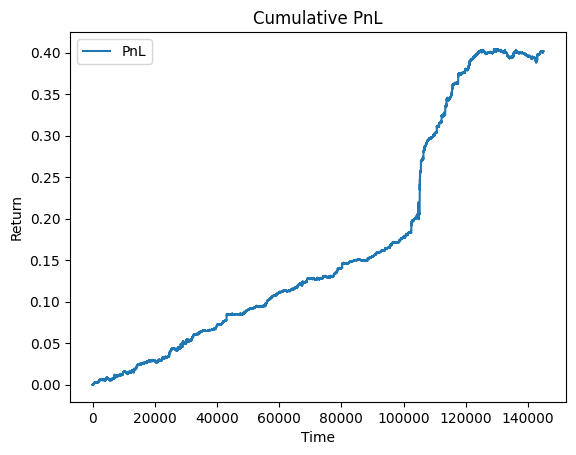

Epoch 30: Loss = -5.157384395599365
Sharpe Ratio for the epoch: 9.6308
Average Weights:



,Weight
Cash,8.496773e-01
FICO,3.176368e-02
MPWR,1.926207e-02
NVR,1.581632e-02
BKNG,1.379827e-02
...,...
BBY,3.978721e-08
TEL,3.883529e-08
ALB,3.717967e-08
AAL,3.531381e-08


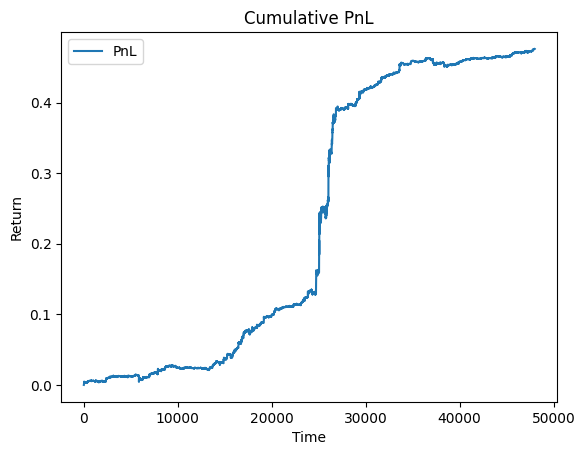

  3%|▎         | 34/1000 [30:33<14:36:27, 54.44s/it]

Sharpe Ratio for the epoch: 8.1690
Average Weights:



,Weight
Cash,8.948590e-01
MPWR,2.057808e-02
FICO,1.653828e-02
BKNG,1.040875e-02
MTD,9.853146e-03
...,...
BBY,2.402408e-08
ALB,2.281275e-08
TEL,2.281252e-08
AAL,2.118701e-08


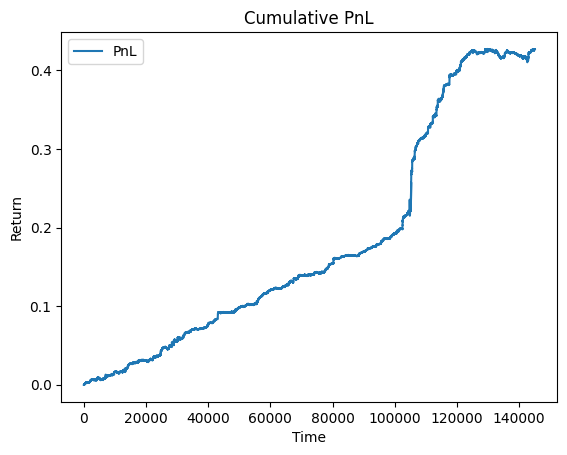

Epoch 35: Loss = -6.134732246398926
Sharpe Ratio for the epoch: 9.9379
Average Weights:



,Weight
Cash,8.519545e-01
FICO,3.187639e-02
MPWR,1.937746e-02
NVR,1.787994e-02
BKNG,1.325742e-02
...,...
BBY,2.590644e-08
TEL,2.466125e-08
ALB,2.462017e-08
AAL,2.286030e-08


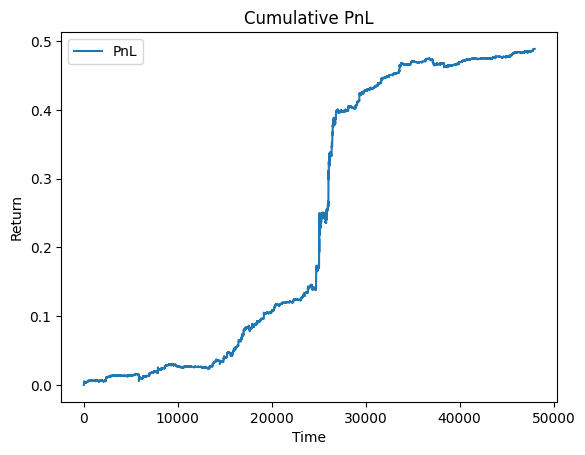

  4%|▍         | 39/1000 [35:14<14:53:43, 55.80s/it]

Sharpe Ratio for the epoch: 8.5440
Average Weights:



,Weight
Cash,8.969994e-01
MPWR,2.110175e-02
FICO,1.638080e-02
BKNG,1.026199e-02
MTD,9.829588e-03
...,...
BBY,1.606838e-08
ALB,1.552132e-08
TEL,1.494382e-08
AAL,1.410155e-08


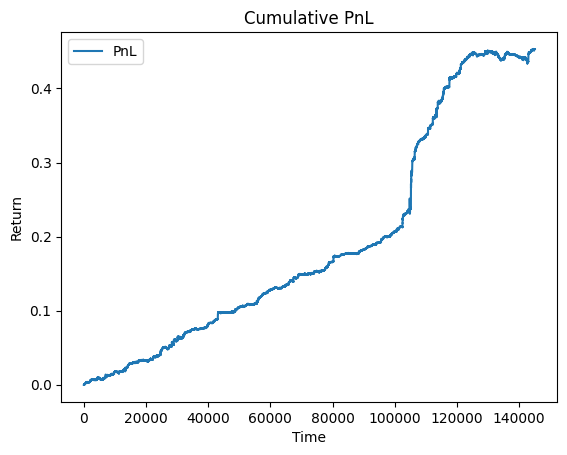

Epoch 40: Loss = -6.928555965423584
Sharpe Ratio for the epoch: 9.8398
Average Weights:



,Weight
Cash,8.516446e-01
FICO,3.165404e-02
MPWR,1.952778e-02
NVR,1.924539e-02
MTD,1.387361e-02
...,...
BBY,1.739972e-08
ALB,1.682342e-08
TEL,1.622847e-08
AAL,1.528194e-08


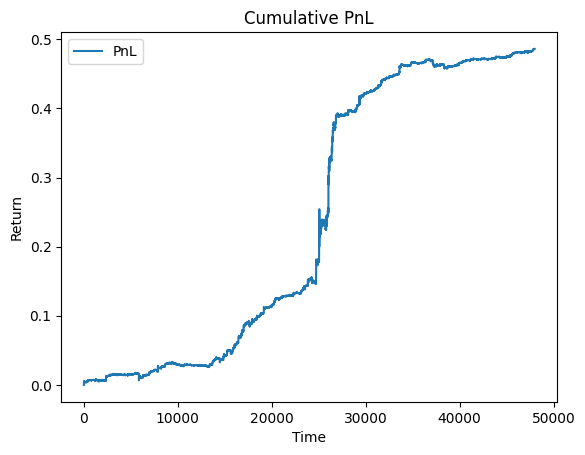

  4%|▍         | 44/1000 [39:51<14:44:09, 55.49s/it]

Sharpe Ratio for the epoch: 8.8697
Average Weights:



,Weight
Cash,9.019814e-01
MPWR,2.073149e-02
FICO,1.546866e-02
BKNG,9.658060e-03
MTD,9.367117e-03
...,...
BBY,1.035853e-08
ALB,1.019403e-08
TEL,9.484126e-09
AAL,9.069276e-09


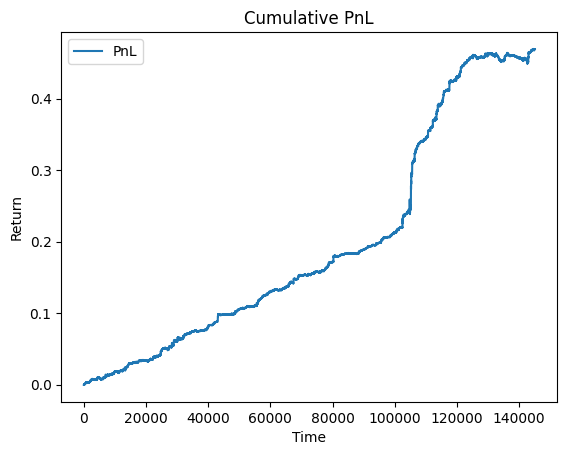

Epoch 45: Loss = -7.357855319976807
Sharpe Ratio for the epoch: 9.5582
Average Weights:



,Weight
Cash,8.549719e-01
FICO,2.898960e-02
NVR,1.863316e-02
MPWR,1.795178e-02
MTD,1.330390e-02
...,...
BBY,1.105965e-08
ALB,1.089471e-08
TEL,1.015813e-08
AAL,9.693196e-09


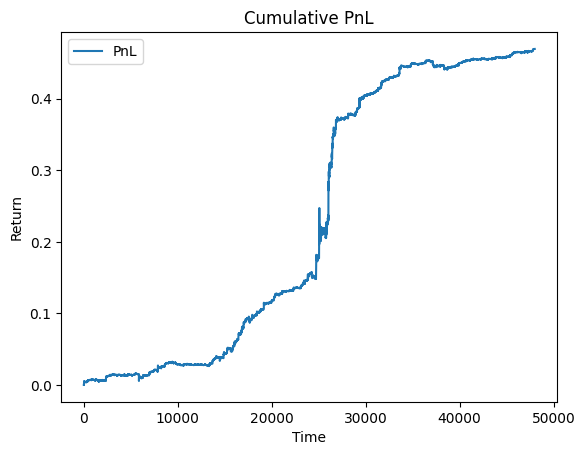

  4%|▍         | 45/1000 [40:47<14:25:32, 54.38s/it]


KeyboardInterrupt: 

In [4]:
for epoch in tqdm(range(num_epochs)):
    if epoch in batch_size_config:
        print(f"Changing batch size to {batch_size_config[epoch]} at epoch {epoch}")
        batch_size = batch_size_config[epoch]
        pipeline = FeaturesPipeline(
            path_to_data,
            padding=padding,
            batch_size=batch_size,
            split_dates=split_dates,
            split_names=split_names
        )

    loss_fn = StreamingSharpeLoss(
        fee=fee,
        asset_names=pipeline.reader.asset_names + ['Cash'],  # Добавляем Cash в список активов
    )
    loss_fn.reset()
    pipeline.reset()
    for common_feats, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('train'):

        # Перевод в тензоры
        common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)       # (T, d_common)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)       # (T, n_assets, d_asset)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)       # (T, n_assets)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)       # (T, n_assets)
        market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)       # (T, n_assets)

        if len(common_feats) != batch_size:
            continue

        cash_left = torch.ones((common_feats.shape[0], 1), dtype=torch.float32, device=device)  # (T, 1)
        for prev_model in prev_models:
            cash_left *= prev_model(common_feats, asset_feats)[:, -1]

        optimizer.zero_grad()

        # Вычисляем веса
        weights = model(common_feats, asset_feats)

        # Обновляем метрику
        loss_value = loss_fn.forward(
            weights=weights,
            returns=fut_ret,
            prev_model_cash=cash_left,
            min_prices=min_prices,
            market_caps=market_caps
        )
        loss_value.backward()

        optimizer.step()

    if (epoch + 1) % log_freq == 0:
        _, weights_df = loss_fn.plot_whole_epoch_loss()  # Выводим Sharpe Ratio за эпоху
        weights_df.to_csv(f'weights_epoch_{epoch + 1}.csv')  # Сохраняем веса в CSV
        # save model
        torch.save(model.state_dict(), f'model_epoch_{epoch + 1}.pth')
        print(f"Epoch {epoch + 1}: Loss = {loss_value.item()}")
    loss_fn.reset()  # Сбрасываем метрику для следующей эпохи

    for common_feats, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('test'):

        common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)
        market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)

        if len(common_feats) != batch_size:
            continue

        cash_left = torch.ones((common_feats.shape[0], 1), dtype=torch.float32, device=device)  # (T, 1)
        for prev_model in prev_models:
            cash_left *= prev_model(common_feats, asset_feats)[:, -1]

        # Вычисляем веса

        weights = model(common_feats, asset_feats)
        loss_fn.forward(weights=weights, returns=fut_ret, prev_model_cash=cash_left, min_prices=min_prices, market_caps=market_caps)

    if (epoch + 1) % log_freq == 0:
        loss_fn.plot_whole_epoch_loss()
    loss_fn.reset()

In [5]:
from copy import deepcopy

prev_models = [deepcopy(model)]

model = SimplePortfolioAllocator(
    cmf_dim=cmf_dim,
    #asset_dim=asset_dim,
    num_assets=num_assets,
)

optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in tqdm(range(num_epochs)):
    if epoch in batch_size_config:
        print(f"Changing batch size to {batch_size_config[epoch]} at epoch {epoch}")
        batch_size = batch_size_config[epoch]
        pipeline = FeaturesPipeline(
            path_to_data,
            padding=padding,
            batch_size=batch_size,
            split_dates=split_dates,
            split_names=split_names
        )

    loss_fn = StreamingSharpeLoss(
        fee=fee,
        asset_names=pipeline.reader.asset_names + ['Cash'],  # Добавляем Cash в список активов
    )
    loss_fn.reset()
    pipeline.reset()
    for common_feats, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('train'):

        # Перевод в тензоры
        common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)       # (T, d_common)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)       # (T, n_assets, d_asset)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)       # (T, n_assets)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)       # (T, n_assets)
        market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)       # (T, n_assets)

        if len(common_feats) != batch_size:
            continue

        cash_left = torch.ones((common_feats.shape[0], 1), dtype=torch.float32, device=device)  # (T, 1)
        for prev_model in prev_models:
            cash_left *= prev_model(common_feats, asset_feats)[:, -1]

        optimizer.zero_grad()

        # Вычисляем веса
        weights = model(common_feats, asset_feats)

        # Обновляем метрику
        loss_value = loss_fn.forward(
            weights=weights,
            returns=fut_ret,
            prev_model_cash=cash_left,
            min_prices=min_prices,
            market_caps=market_caps
        )
        loss_value.backward()

        optimizer.step()

    if (epoch + 1) % log_freq == 0:
        _, weights_df = loss_fn.plot_whole_epoch_loss()  # Выводим Sharpe Ratio за эпоху
        weights_df.to_csv(f'weights_epoch_{epoch + 1}.csv')  # Сохраняем веса в CSV
        # save model
        torch.save(model.state_dict(), f'model_epoch_{epoch + 1}.pth')
        print(f"Epoch {epoch + 1}: Loss = {loss_value.item()}")
    loss_fn.reset()  # Сбрасываем метрику для следующей эпохи

    for common_feats, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('test'):

        common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)
        market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)

        if len(common_feats) != batch_size:
            continue

        cash_left = torch.ones((common_feats.shape[0], 1), dtype=torch.float32, device=device)  # (T, 1)
        for prev_model in prev_models:
            cash_left *= prev_model(common_feats, asset_feats)[:, -1]

        # Вычисляем веса

        weights = model(common_feats, asset_feats)
        loss_fn.forward(weights=weights, returns=fut_ret, prev_model_cash=cash_left, min_prices=min_prices, market_caps=market_caps)

    if (epoch + 1) % log_freq == 0:
        loss_fn.plot_whole_epoch_loss()
    loss_fn.reset()

  0%|          | 0/1000 [00:00<?, ?it/s]

Changing batch size to 1000 at epoch 0


  0%|          | 0/1000 [00:05<?, ?it/s]


KeyboardInterrupt: 